In [1]:
from typing import List
import numpy as np
import pandas as pd
from seqeval.scheme import IOBES, IOB1
from sklearn.metrics import confusion_matrix
from sklearn_crfsuite import metrics

from src.util import load_sentences, preprocess_sentences

### Evaluate Models

In [2]:
from simpletransformers.ner import NERModel,NERArgs


# evaluation set
base_path = 'datasets/conll2003/'
test_samples = load_sentences(base_path + 'test.txt')
test_samples = np.random.choice(test_samples, 1000, False) # sampling without replacement
df_test = preprocess_sentences(test_samples)

# models
models_pre_trained = [
    ('bert', 'dbmdz/bert-base-cased-finetuned-conll03-english', 'bert-base-finetuned'), 
    ('bert', 'dslim/bert-base-NER', 'bert-base-NER'),
    ('bert', 'Davlan/bert-base-multilingual-cased-ner-hrl', 'bert-base-multilingual')
]


# log results
dict_results = {}
for model_class, pre_trained, name in models_pre_trained:
    print("|> Evaluate: {} {} {}".format(model_class, pre_trained, name))

    model = NERModel('bert', pre_trained, use_cuda=False)
    result, model_outputs, preds_list = model.eval_model(df_test)
    
    dict_results[name] = {
        "result": result, 
        "preds_list": preds_list
    }
    
    print("|> {} Result: {}".format(name, result))


/home/vinicius/Workspace/playtika/playtika-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


|> Evaluate: bert dbmdz/bert-base-cased-finetuned-conll03-english bert-base-finetuned


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/125 [00:00<?, ?it/s]

|> bert-base-finetuned Result: {'eval_loss': 1.1740812141895294, 'precision': 0.9105263157894737, 'recall': 0.9251336898395722, 'f1_score': 0.9177718832891247}
|> Evaluate: bert dslim/bert-base-NER bert-base-NER


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/125 [00:00<?, ?it/s]

|> bert-base-NER Result: {'eval_loss': 0.08946374598058174, 'precision': 0.9117475160724723, 'recall': 0.9269162210338681, 'f1_score': 0.9192692987625221}
|> Evaluate: bert Davlan/bert-base-multilingual-cased-ner-hrl bert-base-multilingual


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/125 [00:00<?, ?it/s]

|> bert-base-multilingual Result: {'eval_loss': 0.3565394883736444, 'precision': 0.9358541525995948, 'recall': 0.8235294117647058, 'f1_score': 0.8761061946902654}


In [3]:
def classification_report_entity_level(y_true: List[List[str]], y_pred: List[List[str]], digits=3, output_dict=False):
    from seqeval import metrics
    return metrics.classification_report(y_true, y_pred, mode='strict', scheme=IOBES, digits=digits,
                                         output_dict=output_dict)


def classification_report_token_level(y_true: List[List[str]], y_pred: List[List[str]], digits=3, output_dict=False):
    # listing all possible labels from the ground true
    labels = set()
    _ = [labels.update(set(i)) for i in y_true]

    # remove Others ("O") labels (not a entity)
    labels.remove('O')

    # sort the labels
    sorted_labels = sorted(
        labels,
        key=lambda name: (name[1:], name[0]),
    )

    # compute and return the metrics
    from sklearn_crfsuite import metrics
    return metrics.flat_classification_report(y_true, y_pred, labels=sorted_labels, digits=digits,
                                              output_dict=output_dict)



### Result By Entity

In [4]:
def unpack_tags(x):
    a, b = zip(*x)
    return list(b)
    
y_true = list(map(lambda x: unpack_tags(x), test_samples))

In [5]:
from seqeval import metrics
lst_dfs = []
for name in dict_results.keys():

    y_pred = dict_results[name]['preds_list']
    df = pd.DataFrame(metrics.classification_report(y_true, y_pred, mode=None, scheme=IOB1, digits=3, output_dict=True))
    df = df.transpose()
    df["model"] = name
    df["entity"] = df.index
    lst_dfs.append(df)


df_result = pd.concat(lst_dfs).pivot_table(index="model", columns="entity", values=["f1-score"])
df_result.round(3).sort_values(by=[("f1-score", "micro avg")], ascending=False)


/home/vinicius/Workspace/playtika/playtika-env/lib/python3.6/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score                                           \
entity                      LOC   MISC    ORG    PER macro avg micro avg   
model                                                                      
bert-base-NER             0.935  0.821  0.907  0.958     0.905     0.919   
bert-base-finetuned       0.937  0.794  0.908  0.961     0.900     0.918   
bert-base-multilingual    0.940  0.000  0.906  0.969     0.704     0.876   

                                     
entity                 weighted avg  
model                                
bert-base-NER                 0.920  
bert-base-finetuned           0.918  
bert-base-multilingual        0.821

###  Pairwise Model Analysis

In [42]:
def flatten_list(array2d: List[List[str]]) -> List[str]:
    """Convert a 2d list of strings into a flat list of strings
    """
    flat_list = [item for sublist in array2d for item in sublist]
    return flat_list


def contigency_table(experiment_id_A: str, experiment_id_B: str) -> np.ndarray:
        """Computes a contigency table between two experiments according to their predicted values
        More details: https://en.wikipedia.org/wiki/McNemar%27s_test
        """
        y_pred_A = np.array(flatten_list(dict_results[experiment_id_A]['preds_list']))
        y_pred_B = np.array(flatten_list(dict_results[experiment_id_B]['preds_list']))

        y_true_flatten = np.array(flatten_list(y_true))

        from mlxtend.evaluate import mcnemar_table
        tb = mcnemar_table(y_target=y_true_flatten,
                           y_model1=y_pred_A,
                           y_model2=y_pred_B)
        return tb


def mcnemar_test(experiment_id_A: str, experiment_id_B: str, alpha=0.05) -> tuple:
        """Perform the McNemar Test between two experiments according to their predicted values.
        Null hypothesis: the two algorithms have the same error rate
        High pvalue: Fail to Reject Null Hypothesis. Classifiers have a similar proportion of errors on the test set.
        Small pvalue: Reject Null Hypothesis. Classifiers have a different proportion of errors on the test set.
        More details: https://en.wikipedia.org/wiki/McNemar%27s_test
        """
        from statsmodels.stats.contingency_tables import mcnemar

        # create contingency table
        tb = contigency_table(experiment_id_A, experiment_id_B)

        # calculate mcnemar test
        result = mcnemar(tb, exact=True)
        statistic, pvalue = result.statistic, result.pvalue

        # interpret the p-value
        if pvalue > alpha:
            return statistic, pvalue, 'Same proportions of errors (fail to reject H0)'
        else:
            return statistic, pvalue, 'Different proportions of errors (reject H0)'


In [40]:
print("Available experiments:", dict_results.keys()) 

Available experiments: dict_keys(['bert-base-finetuned', 'bert-base-NER', 'bert-base-multilingual'])


### Contigency Table

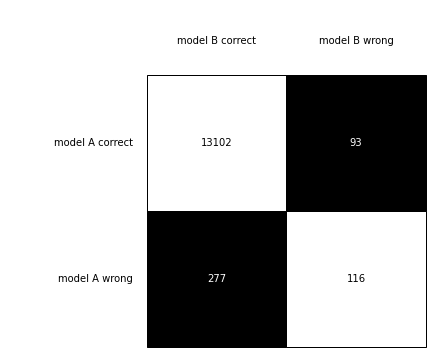

array([[13102,    93],
       [  277,   116]])

In [38]:

import matplotlib.pyplot as plt
from mlxtend.plotting import checkerboard_plot

experiment_id_A = 'bert-base-multilingual'
experiment_id_B = 'bert-base-NER'

tb = contigency_table(experiment_id_A, experiment_id_B)
brd = checkerboard_plot(tb,
    figsize=(5, 5),
    fmt='%d',
    col_labels=['model B correct', 'model B wrong'],
    row_labels=['model A correct', 'model A wrong']
)
plt.show()



### McNemar_test

In [43]:

experiment_id_A = 'bert-base-multilingual'
experiment_id_B = 'bert-base-NER'
d_stats = mcnemar_test(experiment_id_A, experiment_id_B)
d_stats

(93.0, 2.361625487068466e-22, 'Different proportions of errors (reject H0)')

In [45]:
pip list

Package                 Version
----------------------- -----------
absl-py                 1.0.0
aiohttp                 3.8.1
aiosignal               1.2.0
altair                  4.1.0
argon2-cffi             21.1.0
astor                   0.8.1
async-generator         1.10
async-timeout           4.0.1
asynctest               0.13.0
attrs                   21.2.0
backcall                0.2.0
backports.zoneinfo      0.2.1
base58                  2.1.1
bleach                  4.1.0
blinker                 1.4
cachetools              4.2.4
certifi                 2021.10.8
cffi                    1.15.0
charset-normalizer      2.0.9
click                   7.1.2
configparser            5.2.0
cycler                  0.11.0
dataclasses             0.8
datasets                1.16.1
decorator               4.4.2
defusedxml              0.7.1
dill                    0.3.4
docker-pycreds          0.4.0
docopt                  0.6.2
entrypoints             0.3
filelock                3.4.0